In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd
import math
import copy
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

In [2]:
class Particle:
    def __init__(self, initial_pose, weight):
        self.pose = initial_pose
        self.weight = weight
    
    def noise(self): #各粒子にノイズを与える
        ns = rd.normal(0.0, 0.33)  #x方向のノイズ
        self.pose[0] += ns
        ns = rd.normal(0.0, 0.29) #y方向のノイズ
        self.pose[1] += ns
        ns = rd.normal(0.0, 1/10*math.pi) #θ方向のノイズ
        self.pose[2] += ns
        
    def observation_update(self, transponder, distance_dev_rate=0.11, direction_dev=0.56):      
        ##距離と方角を算出##
        diff = transponder - self.pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - self.pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        particle_suggest_pos = np.array( [np.hypot(*diff), phi ] ).T
        
        ##尤度の計算##
        distance_dev = distance_dev_rate*particle_suggest_pos[0]
        cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
        self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(transponder)

class ParticleFilter:
    def __init__(self, initial_pose, time_interval=0.1, time=100.0, transponder=np.array([10,0]), n_particle=100):
        self.particles = [Particle(initial_pose, 1.0/n_particle) for _ in range(n_particle)]
        self.transponder = transponder
        self.n_particle = n_particle
        self.time = time
        self.time_interval = time_interval
            
    def resampling(self):
        ws = np.cumsum([p.weight for p in self.particles]) 
        if ws[-1] < 1e-100: ws = [p + 1e-100 for p in ws]  
            
        step = ws[-1]/len(self.particles) 
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        ps = [] 
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])  
                r += step
            else:
                cur_pos += 1

        self.particles = [copy.deepcopy(p) for p in ps]                   
        for p in self.particles: p.weight = 1.0/len(self.particles)

    def one_step(self, time, elems):
        for p in self.particles: 
            p.noise()
        if int(time)%10 == 0 and time - int(time) == 0.0: 
            for p in self.particles: p.observation_update(self.transponder)
            self.resampling()
            elems[time] = {'x':[p.pose[0] for p in self.particles], 'y':[p.pose[1] for p in self.particles]}
    
    def simulate(self):
        elems = {}
        for i in range(int(self.time/self.time_interval)+1):
            self.one_step(i*self.time_interval, elems)
        self.elems = elems

In [3]:
def run():
    initial_pose = np.array([np.random.normal(0.0,1.0),np.random.normal(0.0,2.0),np.random.normal(0.0,5.0)/180*math.pi])
    time_interval = 0.1
    p = ParticleFilter(initial_pose, time_interval, n_particle=100)
    p.simulate()
    print('end')
    return p.elems


particle_data={}
for _ in range(10):
    raw_data = run()
    for j in raw_data:
        if j not in particle_data.keys():
            particle_data[j] = {}
            particle_data[j]['x'] = raw_data[j]['x'] 
            particle_data[j]['y'] = raw_data[j]['y'] 
        else:
            particle_data[j]['x'] += raw_data[j]['x'] 
            particle_data[j]['y'] += raw_data[j]['y'] 


end
end
end
end
end
end
end
end
end
end


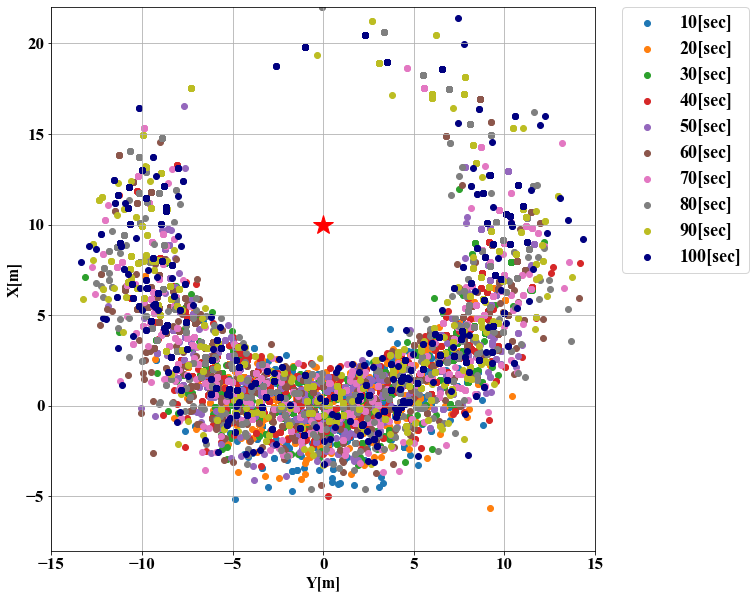

In [4]:
fig = plt.figure(figsize=(10,10)) 
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 17
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_xlim(-15, 15)
ax.set_ylim(-8, 22)
ax.set_xlabel("Y[m]",fontsize=16)                 
ax.set_ylabel("X[m]",fontsize=16) 
ax.grid(True)
plt.plot(0, 10, marker='*',markersize=20, color='red')
for i in range(10,101, 10):
    x,y = particle_data[i]['x'], particle_data[i]['y']
    if i == 100:
        ax.scatter(y, x, label=str(i)+'[sec]', color='navy')
    else:
        ax.scatter(y,x, label=str(i)+'[sec]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.savefig('02.png')
plt.show()